In [1]:
import random
import numpy as np
import requests as re
from skimage import io
import matplotlib.pyplot as plt
import geopandas as gpd
from clean_line_breaks import *
import pickle

%matplotlib inline

## Part 1

In [2]:
Berkeley_lat = '37.87'
Berkeley_lon = '-122.26'
date = '2014-05-21'
my_api_key = 'ikemtEt9CWAcPxhL62keINqViaBCX65LkAoiT9pF'

base_url = 'https://api.nasa.gov/planetary/earth/imagery/'
image_query = base_url+'?lat='+Berkeley_lat+'&lon='+Berkeley_lon+'&date='+date
image_query = image_query+'&api_key='+my_api_key

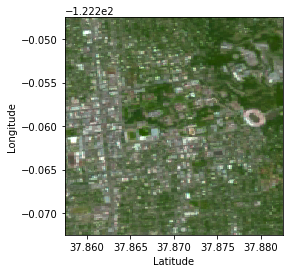

In [3]:
r = re.get(base_url, params={'lat':Berkeley_lat, 'lon':Berkeley_lon,
                            'date':date, 'api_key':my_api_key})
url = r.url

def download_file(url, local_filename):
    r = re.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for  chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    return local_filename

nasa_reply_url = r.json()['url']
download_file(nasa_reply_url, 'image.png');
extent = [float(Berkeley_lat) - 0.0125,float(Berkeley_lat) + 0.0125, 
         float(Berkeley_lon) - 0.0125,float(Berkeley_lon) + 0.0125,]
im = io.imread('image.png')
plt.imshow(im, extent=extent)
plt.ylabel('Longitude') and plt.xlabel('Latitude');

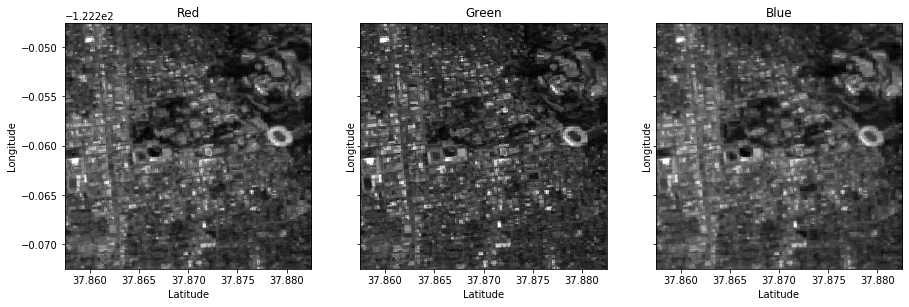

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
titles = ['Red', 'Green', 'Blue']

for i in range(len(im.shape)):
    axes[i].imshow(im[:,:,i], cmap='gray', extent=extent)
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('Longitude') and axes[i].set_xlabel('Latitude')

In [5]:
south_Berkeley_lat = str(float(Berkeley_lat) - 0.025)
r = re.get(base_url, params={'lat':south_Berkeley_lat, 'lon':Berkeley_lon,
                            'date':date, 'api_key':my_api_key})
url = r.url
nasa_reply_url = r.json()['url']
download_file(nasa_reply_url, 'south_image.png')

south_im = io.imread('south_image.png')

north_Berkeley_lat = str(float(Berkeley_lat) + 0.025)
r = re.get(base_url, params={'lat':north_Berkeley_lat, 'lon':Berkeley_lon,
                            'date':date, 'api_key':my_api_key})
url = r.url
nasa_reply_url = r.json()['url']
download_file(nasa_reply_url, 'north_image.png')

north_im = io.imread('north_image.png')

north_Berkeley_lat = str(float(Berkeley_lat) + 0.05)
r = re.get(base_url, params={'lat':north_Berkeley_lat, 'lon':Berkeley_lon,
                            'date':date, 'api_key':my_api_key})
url = r.url
nasa_reply_url = r.json()['url']
download_file(nasa_reply_url, 'north2_image.png')

north2_im = io.imread('north2_image.png')
north_im = np.vstack((north2_im, north_im))

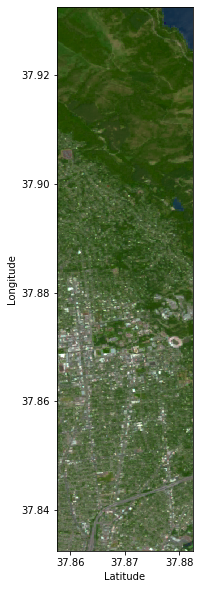

In [6]:
long_berk = np.vstack((north_im, im, south_im))
fig, ax = plt.subplots(1,1, figsize=(10,10))
extent = [float(Berkeley_lat) - 0.0125,float(Berkeley_lat) + 0.0125, 
                                         float(south_Berkeley_lat) - 0.0125, float(north_Berkeley_lat) + 0.0125]
plt.imshow(long_berk, axes=ax, extent=extent)
ax.set_ylabel('Longitude') and ax.set_xlabel('Latitude');

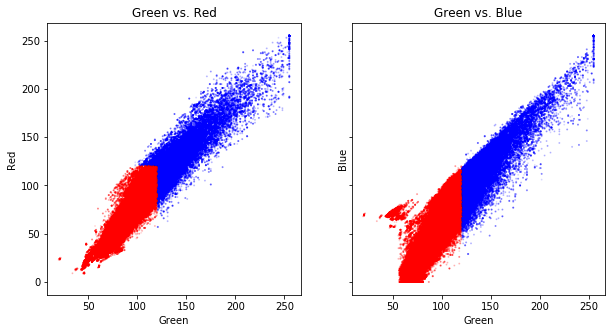

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
redblue_ys = [long_berk[:,:,0].flatten(), long_berk[:,:,2].flatten()]

for i in range(2):
    x, y = long_berk[:,:,1].flatten(), redblue_ys[i]
    axes[i].scatter(x, y, alpha=0.1, s=1, c=np.where(x > 120, 'b', np.where(y > 120, 'b', 'r')))
    axes[i].set_xlabel(titles[1]) and axes[i].set_ylabel(titles[0:3:2][i])
    axes[i].set_title(titles[1] + ' vs. ' + titles[0:3:2][i])

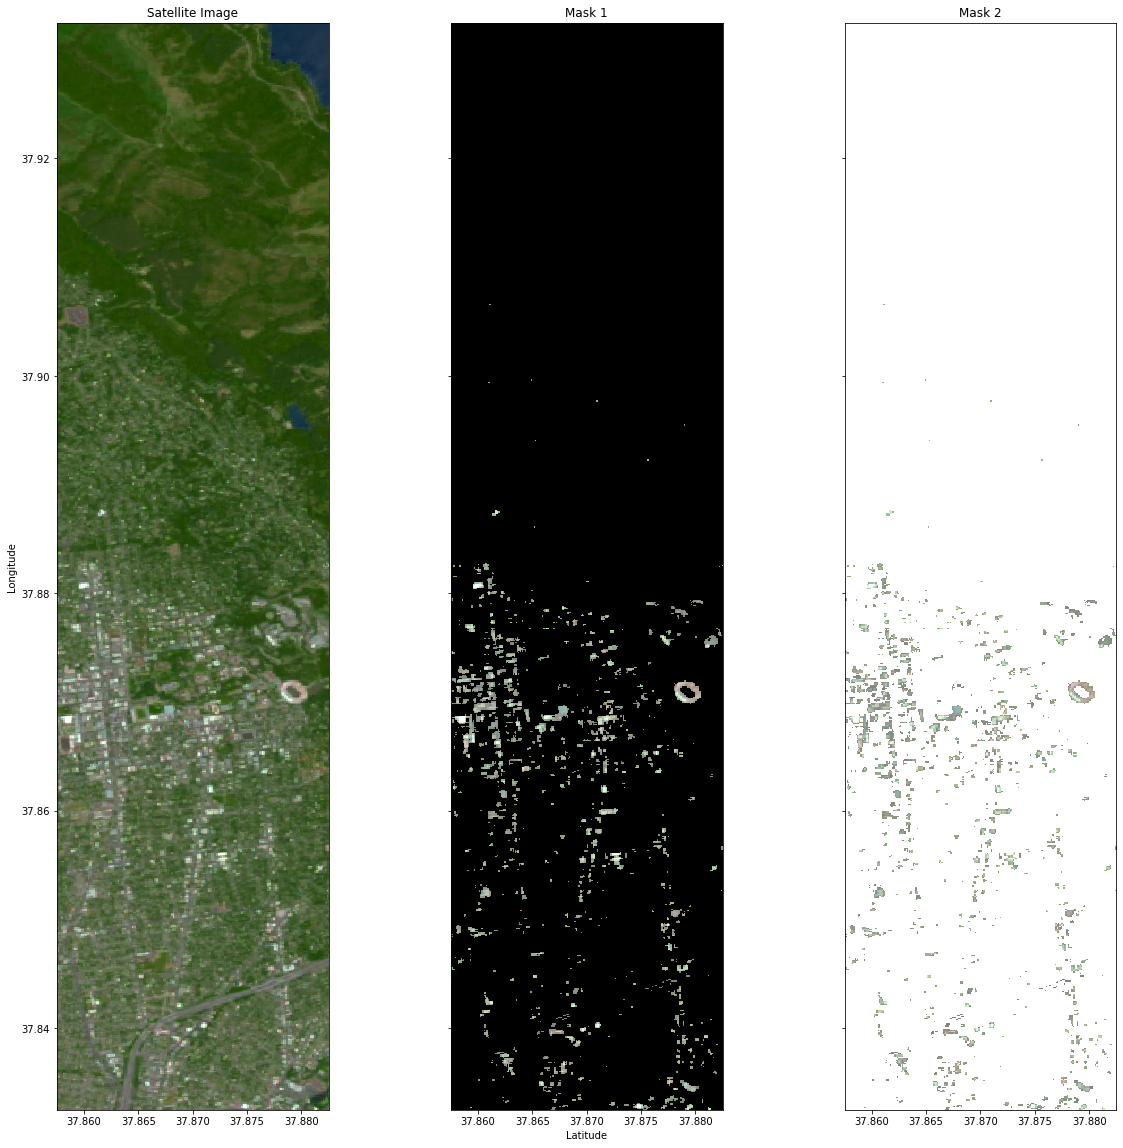

In [8]:
mask = np.full_like(long_berk, 0)
cond = np.where(long_berk.sum(2) > 360)
for i, j in zip(cond[0], cond[1]):
    if False in (long_berk[i][j] > 120):
        pass
    else:
        mask[i][j] = long_berk[i][j]

fig, axes = plt.subplots(1,3,figsize=(20,20), sharex=True, sharey=True)
axes[0].imshow(long_berk, extent=extent)
axes[0].set_ylabel('Longitude')
axes[0].set_title('Satellite Image')
axes[1].imshow(mask, extent=extent)
axes[1].set_title('Mask 1')
axes[1].set_xlabel('Latitude')
axes[2].imshow(np.where(mask == 0, 255, mask), extent=extent)
axes[2].set_title('Mask 2');

## Part 2

In [9]:
def leopard_start(grid, start=(0,0), rand_start=False):
    assert grid.sum() == 0, 'Must be an empty starting grid.'
    grid = np.copy(grid)
    if rand_start is True:
        grid[np.random.randint(len(grid))][np.random.randint(len(grid))] = 1
    elif rand_start is False:
        x, y = start
        grid[y][x] = 1
    return grid

def leopard_move(grid, row_edge, col_edge):
    def leopard_prob(row, col, row_edge, col_edge):
        right, left, up, down = (0,1), (0,-1), (-1,0), (1,0)
        right_down, right_up = (1,1), (-1,1)
        left_down, left_up = (1,-1), (-1,-1)
        outcomes = 0
        if row == 0:
            if col == 0:
                outcomes = [right, down, right_down]
            elif col == col_edge:
                outcomes = [left, down, left_down]
            else:
                outcomes = [right, left, down, right_down, left_down]
        elif col == 0:
            if row == row_edge:
                outcomes = [right, up, right_up]
            else:
                outcomes = [right, up, down, right_up, right_down]
        elif row == row_edge:
            if col == col_edge:
                outcomes = [up, left, left_up]
            else:
                outcomes = [right, left, up, right_up, left_up]
        elif col == col_edge:
            outcomes = [left, up, down, left_up, left_down]
        else:
            outcomes = [right, left, up, down, 
                        right_down, right_up, left_down, left_up]
        assert len(grid) not in [i for x in outcomes for i in x]
        return random.choice(outcomes)
    grid = np.copy(grid)
    row, col = np.where(grid == 1)
    row, col = int(row), int(col)
    grid[row][col] = 0
    choice_row, choice_col = leopard_prob(row, col, row_edge, col_edge)
    grid[row + choice_row][col + choice_col] = 1
    return grid

def leopard_track(grid, days, rand_start=False):
    grid = leopard_start(grid=grid, rand_start=rand_start)
    row_edge=int(grid.shape[0] - 1)
    col_edge=int(grid.shape[1] - 1)
    grid_stack = [grid]
    for i in range(days - 1):
        grid_stack.append(leopard_move(grid_stack[-1], row_edge, col_edge))
    return np.array(grid_stack)

def ln_plottable(arr):
    x, y = [], []
    x.append(np.where(arr == 1)[2])
    y.append(np.where(arr == 1)[1])
    return x[0], y[0]

def camera_obs(grid, cam_loc):
    assert type(cam_loc) is tuple and len(cam_loc) is 2
    row, col = cam_loc
    if type(grid) is list:
        cam_stack = []
        for i in grid:
            cam_stack.append(camera_obs(i, cam_loc=cam_loc))
        return sum(cam_stack)
    else:
        return grid[:, row, col]
    
def monte_sim(grid, days, number, simulations, camera_loc, rand_start=False, isolate=False):
    monte_container = []
    if isolate == False:
        for i in range(number):
            monte_container.append(np.array([camera_obs([leopard_track(grid, days, rand_start)
                                                         for _ in range(i+1)], camera_loc) for _ in range(simulations)]).sum(axis=1))
    elif isolate == True:
        monte_container = np.array([camera_obs([leopard_track(grid, days, rand_start)
                                                for _ in range(number)], camera_loc) for _ in range(simulations)]).sum(axis=1)
    return monte_container

In [10]:
leopard_grid = np.zeros([(10),(10)])
ol = 'lower'
ln_styles = ['solid','dotted','dashed','dashdot']

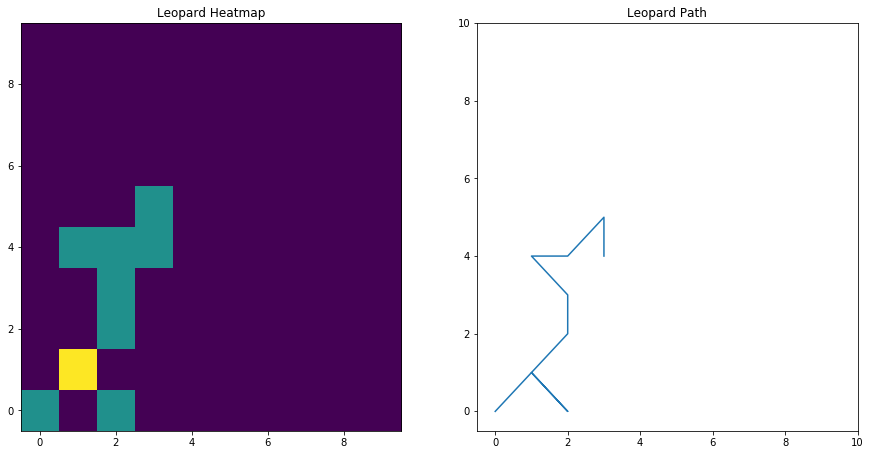

In [11]:
leopard_10 = leopard_track(leopard_grid, 10)
x, y = ln_plottable(leopard_10)

fig, axes = plt.subplots(1, 2, figsize=(15,7.5))
axes[0].imshow(sum(leopard_10), origin=ol, aspect='auto')
axes[0].set_title('Leopard Heatmap')
axes[1].plot(x, y, '-')
axes[1].set_title('Leopard Path')
axes[1].set_xlim(-0.5,10) and axes[1].set_ylim(-0.5,10);

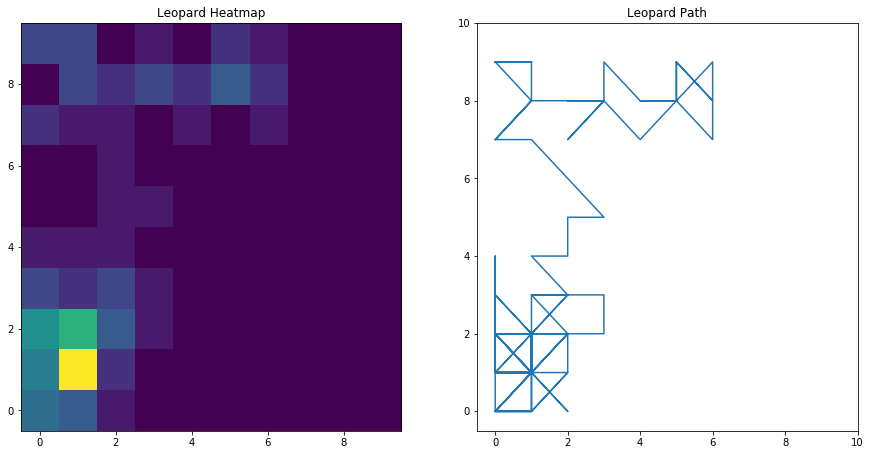

In [12]:
leopard_100 = leopard_track(leopard_grid, 100)
x, y = ln_plottable(leopard_100)

fig, axes = plt.subplots(1, 2, figsize=(15,7.5))
axes[0].imshow(sum(leopard_100), origin=ol, aspect='auto')
axes[0].set_title('Leopard Heatmap')
axes[1].plot(x, y, '-')
axes[1].set_title('Leopard Path')
axes[1].set_xlim(-0.5,10) and axes[1].set_ylim(-0.5,10);

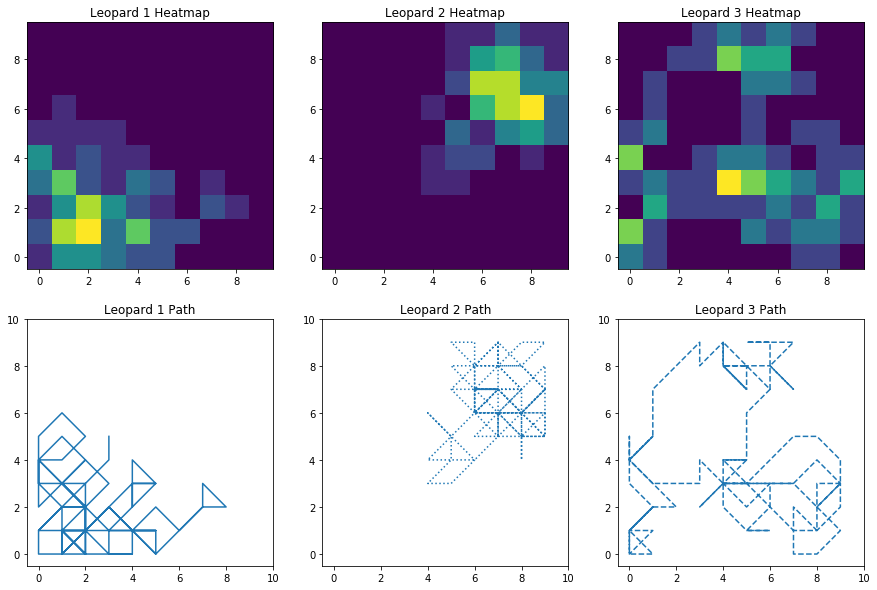

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
three_leopards = [leopard_track(leopard_grid, 100, rand_start=True)
                  for _ in range(3)]

for i in range(len(three_leopards)):
    axes[0][i].imshow(sum(three_leopards[i]), origin=ol, aspect='auto')
    axes[0][i].set_title('Leopard '+ str(i + 1) +' Heatmap')
    x, y = ln_plottable(three_leopards[i])
    axes[1][i].plot(x, y, ls=ln_styles[i])
    axes[1][i].set_title('Leopard '+ str(i + 1) +' Path')
    axes[1][i].set_xlim(-0.5,10) and axes[1][i].set_ylim(-0.5,10);

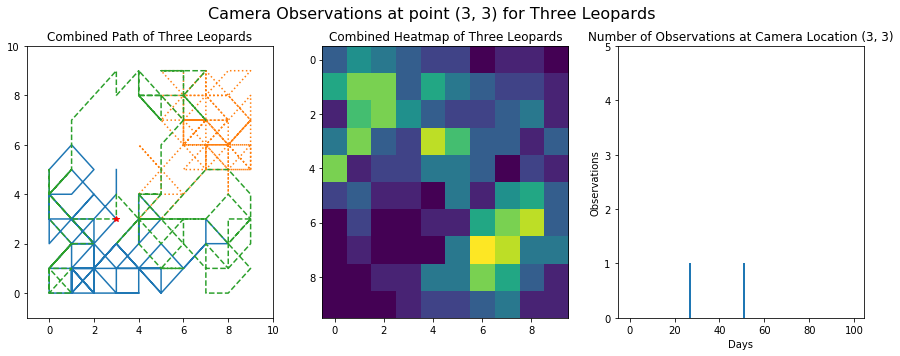

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
cam_loc = (3,3)
cam_obs = camera_obs(three_leopards, cam_loc)

axes[1].imshow(sum([sum(_) for _ in three_leopards]), aspect='auto')
axes[1].set_title('Combined Heatmap of Three Leopards')
for i in range(len(three_leopards)):
    x, y = ln_plottable(three_leopards[i])
    axes[0].plot(x, y, ls=ln_styles[i])
axes[0].plot(cam_loc[0], cam_loc[1],'r*')
axes[0].set_title('Combined Path of Three Leopards')
axes[0].set_xlim(-1,10) and axes[0].set_ylim(-1,10)
axes[2].bar(list(range(100)), cam_obs)
axes[2].set_xlabel('Days') and axes[2].set_ylabel('Observations')
axes[2].set_title('Number of Observations at Camera Location ' + str(cam_loc))
axes[2].set_ylim(0, max(cam_obs) + 4)
fig.suptitle('Camera Observations at point '+str(cam_loc)+' for Three Leopards', size=16, y=.99);

In [15]:
monte_12 = monte_sim(leopard_grid, 100, 12, 1000, (3,3), rand_start=True)

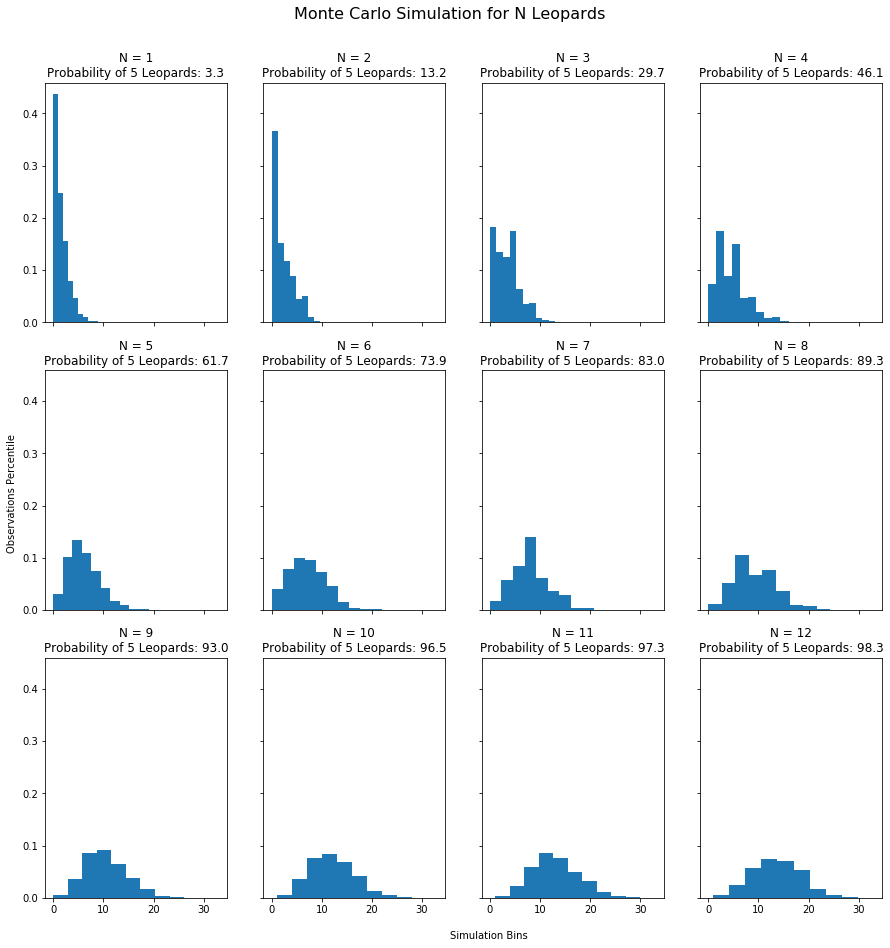

In [16]:
fig, axes = plt.subplots(3, 4, figsize=(15,15), sharey=True, sharex=True)
prob_str ='\nProbability of 5 Leopards: '
prob = [len(np.where(monte_12[i] >= 5)[0]) / 10 for i in range(12)]

for i in range(4):
    axes[0][i].hist(monte_12[i], density=True)
    axes[0][i].set_title('N = ' + str(i + 1) + prob_str + str(prob[i]))
for i in range(4,8):
    axes[1][i-4].hist(monte_12[i], density=True)
    axes[1][i-4].set_title('N = ' + str(i + 1) + prob_str + str(prob[i]))
for i in range(8,12):
    axes[2][i-8].hist(monte_12[i], density=True)
    axes[2][i-8].set_title('N = ' + str(i + 1) + prob_str + str(prob[i]))
fig.text(0.09, 0.5, 'Observations Percentile', 
         va='center', rotation='vertical')
fig.text(0.5, 0.09, 'Simulation Bins', 
         va='center', rotation='horizontal')
fig.suptitle('Monte Carlo Simulation for N Leopards', size=16, y=.95);

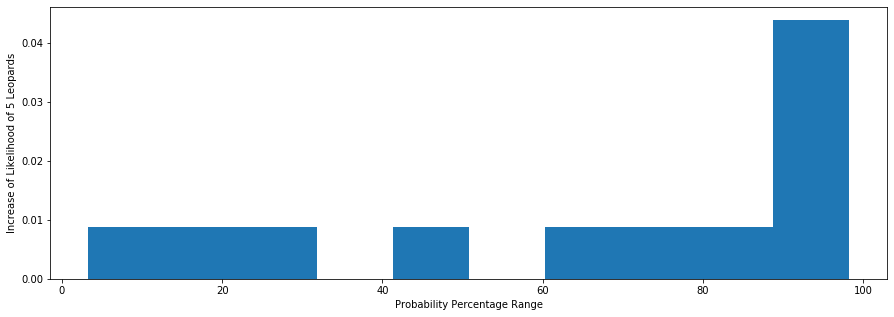

In [17]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.hist(prob, density=True)
ax.set_ylabel('Increase of Likelihood of 5 Leopards') and ax.set_xlabel('Probability Percentage Range');

In [18]:
monte_a = monte_sim(leopard_grid, 100, 3, 1000, (3,3), rand_start=True, isolate=True)
monte_b = monte_sim(leopard_grid, 100, 3, 1000, (1,1), rand_start=True, isolate=True)
monte_c = monte_sim(leopard_grid, 100, 3, 1000, (5,5), rand_start=True, isolate=True)

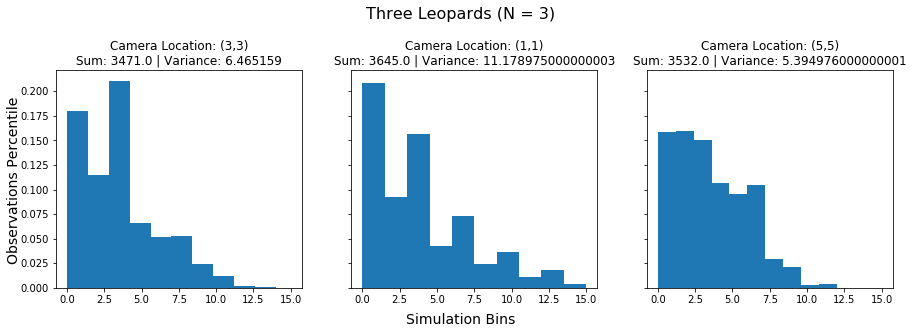

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True, sharex=True)

axes[0].hist(monte_a, density=True)
axes[0].set_title('Camera Location: (3,3)\nSum: '+str(monte_a.sum())+' | Variance: '+str(monte_a.var()))
axes[1].hist(monte_b, density=True)
axes[1].set_title('Camera Location: (1,1)\nSum: '+str(monte_b.sum())+' | Variance: '+str(monte_b.var()))
axes[2].hist(monte_c, density=True)
axes[2].set_title('Camera Location: (5,5)\nSum: '+str(monte_c.sum())+' | Variance: '+str(monte_c.var()))
fig.text(0.5, 0, 'Simulation Bins', ha='center', size=14)
fig.text(0.08, 0.5, 'Observations Percentile', va='center', rotation='vertical', size=14)
fig.suptitle('Three Leopards (N = 3)', size=16, y=1.1);

## Part 3

In [20]:
df = clean_line_breaks(gpd.read_file('ZAF_rrd/ZAF_rails.shp'))
df['Distance'] = [i.length for i in df.geometry]
sa_title = 'South African Railroad Network'

def dist_indexer(station1, station2, df):
    for i in range(len(df)):
        line_lats, line_lons = df.geometry[i].xy
        if np.sum((np.sum([line_lats[0], line_lons[0]] == station1) > 0 and np.sum([line_lats[-1], line_lons[-1]] == station2) > 0) > 0 or 
                  np.sum([line_lats[0], line_lons[0]] == station2) > 0 and np.sum([line_lats[-1], line_lons[-1]] == station1) > 0) > 0:
            return df.Distance[i]
    
def polyline_indexer(station1, station2, df):
    for i in range(len(df)):
        line_lats, line_lons = df.geometry[i].xy
        if np.sum((np.sum([line_lats[0], line_lons[0]] == station1) > 0 and np.sum([line_lats[-1], line_lons[-1]] == station2) > 0) > 0 or 
                  np.sum([line_lats[0], line_lons[0]] == station2) > 0 and np.sum([line_lats[-1], line_lons[-1]] == station1) > 0) > 0:
            return df.geometry[i].xy
        
def dijkstra_matrix(start, stations, dst_matrix):
    D = np.full(len(stations), np.inf)
    P = np.full(len(stations), np.nan)
    I = np.full(len(stations), 0)
    D[start] = 0
    while len(I) > sum(I):
        inactive = np.where(I==0)
        min_dst = np.where(D == np.min(D[inactive]))[0]
        min_inter = np.intersect1d(min_dst, inactive)[0]
        I[min_inter] = 1
        D_dsts = dst_matrix[min_inter, :]
        non_inf = np.where(D_dsts != np.inf)
        k = non_inf[0][np.isin(non_inf, inactive)[0]]
        for i in range(len(k)):
            if D[min_inter] + D_dsts[k[i]] < D[k[i]]:
                D[k[i]] = D[min_inter] + D_dsts[k[i]]
                P[k[i]] = min_inter
    return D, P

def dijkstra_shortest_route(start, end, nodes, dst_matrix):
    distances, connections = dst_matrix[end]
    route = []
    while start != end:
        next_node = int(connections[start])
        distance = distances[start]
        route.append((start, next_node, distance))
        start = next_node
    return route

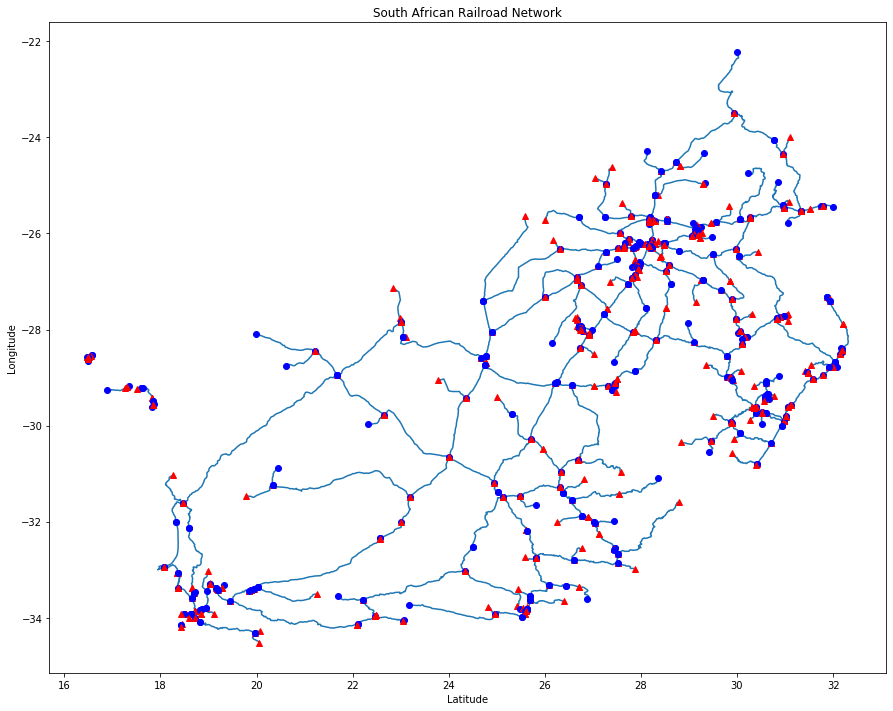

In [21]:
fig, ax = plt.subplots(1,1,figsize=(15,15))

df.plot(ax=ax)
for line in df['geometry']:
    ax.plot(line.xy[0][0], line.xy[1][0], 'bo')
    ax.plot(line.xy[0][-1], line.xy[1][-1], 'r^')
ax.set_title(sa_title)
ax.set_xlabel('Latitude') and ax.set_ylabel('Longitude');

In [22]:
start_lats, start_lons = [], []
end_lats, end_lons = [], []
for i in range(len(df)):
    line_lats, line_lons = df['geometry'][i].xy
    start_lats.append(line_lats[0])
    start_lons.append(line_lons[0])
    end_lats.append(line_lats[-1])
    end_lons.append(line_lons[-1])

list_with_duplicates = np.array(list(zip(start_lats+end_lats, start_lons+end_lons)))
stations = np.unique(list_with_duplicates, axis=0)

len(stations)

457

In [23]:
L = np.zeros((len(stations),len(stations)))
for i in range(len(df)): ### index of link
    line_lats, line_lons = df['geometry'][i].xy
    for j in range(len(stations)): ### index of node
        if np.sum([line_lats[0], line_lons[0]] == stations[j,:]) == 2:
            start_j = j
        if np.sum([line_lats[-1], line_lons[-1]] == stations[j,:]) == 2:
            end_j = j
    L[start_j,end_j] = 1
    L[end_j,start_j] = 1

In [24]:
D = np.full_like(L, np.inf)
for i, (j, k) in enumerate(zip(L, D)):
    for o, (l, p) in enumerate(zip(j, k)):
        if l == 1 and p == np.inf:
            D[i][o] = dist_indexer(stations[i], stations[o], df)
            D[o][i] = dist_indexer(stations[i], stations[o], df)

assert len(D[np.where(D != np.inf)]) == len(L[np.where(L > 0)])

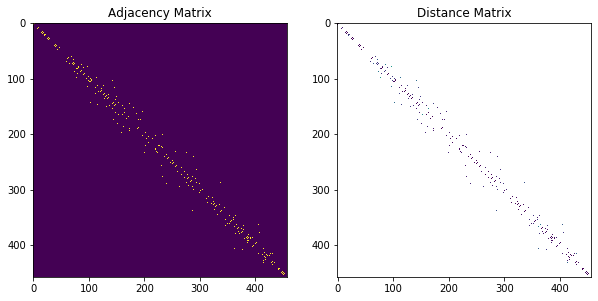

In [25]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(L)
axes[0].set_title('Adjacency Matrix')
axes[1].imshow(D)
axes[1].set_title('Distance Matrix');

In [26]:
dij_matrix = []
for i in range(len(stations)):
    dij_matrix.append(dijkstra_matrix(i, stations, D))

with open('Dijkstra_Train_Matrix.p', 'wb') as f:
    djm = pickle.dump(dij_matrix, f)

with open('Dijkstra_Train_Matrix.p', 'rb') as f:
    dij_train_matrix = pickle.load(f)

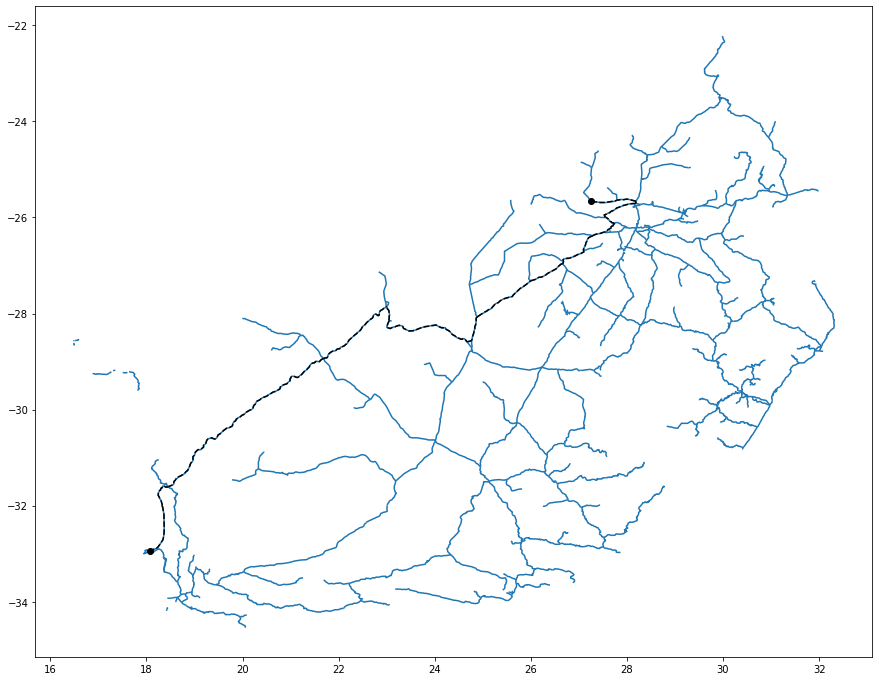

In [27]:
start, end = 20, 200
stations_20_200 = dijkstra_shortest_route(start, end, stations, dij_train_matrix)
route = [(i,j) for i,j,k in stations_20_200]

fig, ax = plt.subplots(1, 1, figsize=(15,15))
df.plot(ax=ax)

for i, j in route:
    x, y = polyline_indexer(stations[i], stations[j], df)
    ax.plot(x, y, 'k--')
plt.plot(stations[start][0], stations[start][1], 'ko')
plt.plot(stations[end][0], stations[end][1], 'ko');

Station for facility? Enter 1 to 457:199


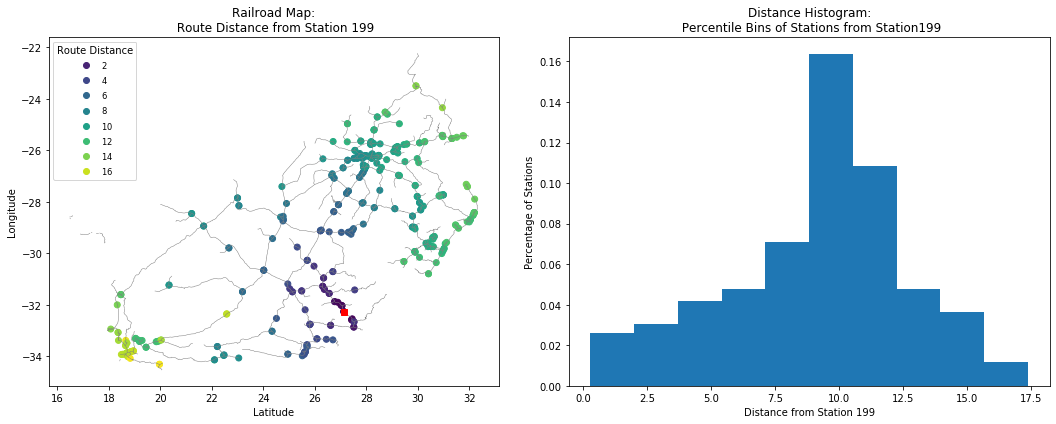

In [28]:
k = input('Station for facility? Enter 1 to '+str(len(stations))+':')

station = int(k) - 1
all_stations_dst = dij_train_matrix[station]
distances, other_stations = all_stations_dst
distances = distances[distances != np.inf][distances[distances != np.inf] > 0]
other_stations = other_stations[~np.isnan(other_stations)]

connected_stations = []
for i in other_stations:
    connected_stations.append(stations[int(i)])

fig, axes = plt.subplots(1, 2, figsize=(15,6))
df.plot(ax=axes[0], color='gray', lw=0.5)
lat, lon = np.array(connected_stations).T
scatter = axes[0].scatter(lat, lon, c = distances)
axes[0].plot(stations[station][0], stations[station][1], 'rs')
axes[0].legend(*scatter.legend_elements(), fontsize = 'small', title ='Route Distance')
axes[0].set_ylabel('Longitude') and axes[0].set_xlabel('Latitude')
axes[0].set_title('Railroad Map:\n Route Distance from Station '+k)
axes[1].hist(distances, density=True)
axes[1].set_ylabel('Percentage of Stations') and axes[1].set_xlabel('Distance from Station '+ k)
axes[1].set_title('Distance Histogram:\n Percentile Bins of Stations from Station'+ k)
plt.tight_layout();

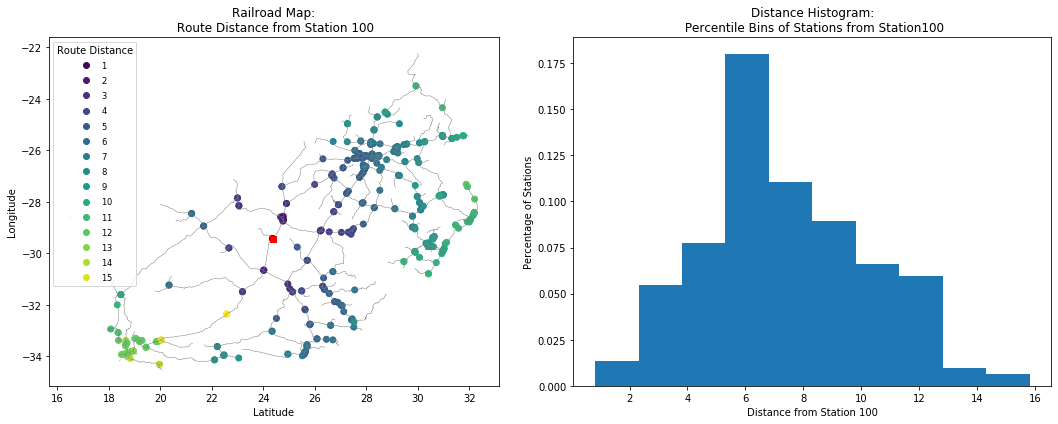

In [29]:
k = '100'
station = int(k) - 1
all_stations_dst = dij_train_matrix[station]
distances, other_stations = all_stations_dst
distances = distances[distances != np.inf][distances[distances != np.inf] > 0]
other_stations = other_stations[~np.isnan(other_stations)]

connected_stations = []
for i in other_stations:
    connected_stations.append(stations[int(i)])

fig, axes = plt.subplots(1, 2, figsize=(15,6))
df.plot(ax=axes[0], color='gray', lw=0.5)
lat, lon = np.array(connected_stations).T
scatter = axes[0].scatter(lat, lon, c = distances)
axes[0].plot(stations[station][0], stations[station][1], 'rs')
axes[0].legend(*scatter.legend_elements(), 
          fontsize = 'small', title ='Route Distance')
axes[0].set_ylabel('Longitude') and axes[0].set_xlabel('Latitude')
axes[0].set_title('Railroad Map:\n Route Distance from Station '+k)
axes[1].hist(distances, density=True)
axes[1].set_ylabel('Percentage of Stations') and axes[1].set_xlabel('Distance from Station '+ k)
axes[1].set_title('Distance Histogram:\n Percentile Bins of Stations from Station'+ k)
plt.tight_layout();

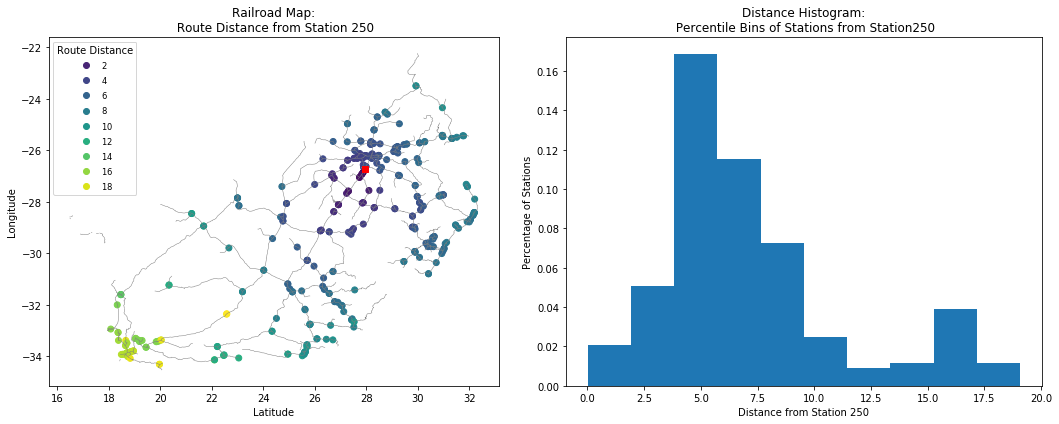

In [30]:
k = '250'
station = int(k) - 1
all_stations_dst = dij_train_matrix[station]
distances, other_stations = all_stations_dst
distances = distances[distances != np.inf][distances[distances != np.inf] > 0]
other_stations = other_stations[~np.isnan(other_stations)]

connected_stations = []
for i in other_stations:
    connected_stations.append(stations[int(i)])

fig, axes = plt.subplots(1, 2, figsize=(15,6))
df.plot(ax=axes[0], color='gray', lw=0.5)
lat, lon = np.array(connected_stations).T
scatter = axes[0].scatter(lat, lon, c = distances)
axes[0].plot(stations[station][0], stations[station][1], 'rs')
axes[0].legend(*scatter.legend_elements(), 
          fontsize = 'small', title ='Route Distance')
axes[0].set_ylabel('Longitude') and axes[0].set_xlabel('Latitude')
axes[0].set_title('Railroad Map:\n Route Distance from Station '+k)
axes[1].hist(distances, density=True)
axes[1].set_ylabel('Percentage of Stations') and axes[1].set_xlabel('Distance from Station '+ k)
axes[1].set_title('Distance Histogram:\n Percentile Bins of Stations from Station'+ k)
plt.tight_layout();

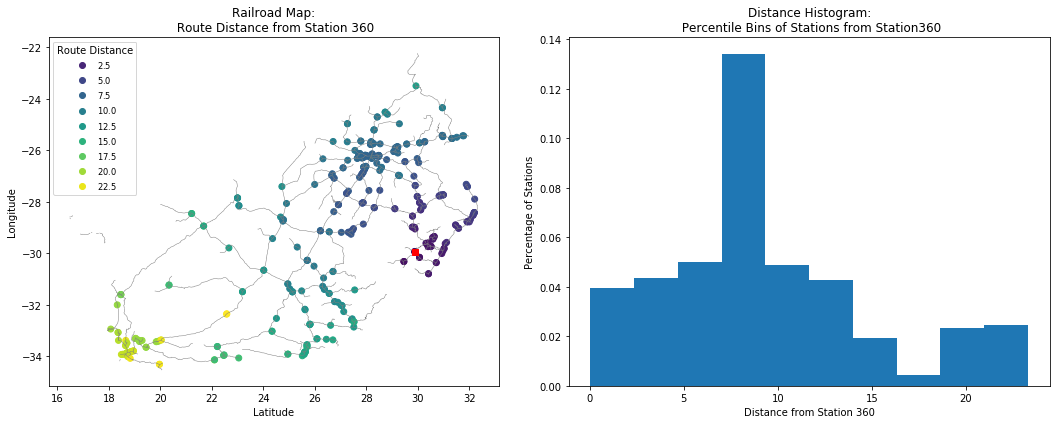

In [31]:
k = '360'
station = int(k) - 1
all_stations_dst = dij_train_matrix[station]
distances, other_stations = all_stations_dst
distances = distances[distances != np.inf][distances[distances != np.inf] > 0]
other_stations = other_stations[~np.isnan(other_stations)]

connected_stations = []
for i in other_stations:
    connected_stations.append(stations[int(i)])

fig, axes = plt.subplots(1, 2, figsize=(15,6))
df.plot(ax=axes[0], color='gray', lw=0.5)
lat, lon = np.array(connected_stations).T
scatter = axes[0].scatter(lat, lon, c = distances)
axes[0].plot(stations[station][0], stations[station][1], 'rs')
axes[0].legend(*scatter.legend_elements(), 
          fontsize = 'small', title ='Route Distance')
axes[0].set_ylabel('Longitude') and axes[0].set_xlabel('Latitude')
axes[0].set_title('Railroad Map:\n Route Distance from Station '+k)
axes[1].hist(distances, density=True)
axes[1].set_ylabel('Percentage of Stations') and axes[1].set_xlabel('Distance from Station '+ k)
axes[1].set_title('Distance Histogram:\n Percentile Bins of Stations from Station'+ k)
plt.tight_layout();